### Disease embedding

In [1]:
import plotly.graph_objects as go
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import seaborn as sns
from sklearn.metrics import classification_report

import sys
sys.path.insert(1, '../')
from utils.packages import *

def load_model(path, model):
    # load pretrained model and update weights
    pretrained_dict = torch.load(path)
    model_dict = model.state_dict()
    # 1. filter out unnecessary keys
    pretrained_dict = {k: v for k, v in pretrained_dict.items() if k in model_dict}
    # 2. overwrite entries in the existing state dict
    model_dict.update(pretrained_dict)
    # 3. load the new state dict
    model.load_state_dict(model_dict)
    return model

global_params = {
    'max_seq_len': 64,
    'gradient_accumulation_steps': 1
}

optim_param = {
    'lr': 3e-5,
    'warmup_proportion': 0.1,
    'weight_decay': 0.01
}

train_params = {
    'batch_size': 10,
    'use_cuda': True,
    'max_len_seq': global_params['max_seq_len'],
    'device': 'cuda' #change this to run on cuda #'cuda:0'
}

dataset_name = 'Synthea/Final_cohorts/'

feature_types = {'diagnosis':True, 'medications':False, 'procedures':False}

if (feature_types['diagnosis'] and feature_types['medications'] and not feature_types['diagnosis']):
    print("Do only use diagnosis")
    code_voc = 'MLM_diagnosmedcodes.npy'
    age_voc = 'MLM_age.npy'

elif (feature_types['diagnosis'] and not feature_types['medications']):
    code_voc = 'MLM_diagnoscodes.npy'
    age_voc = 'MLM_age.npy'

else:
    code_voc = 'MLM_diagnosmedproccodes.npy'
    age_voc = 'MLM_age.npy'

files = {'code':'../data/vocabularies/' + dataset_name + code_voc,
             'age':'../data/vocabularies/' + dataset_name + age_voc,
        }

tokenizer = EHRTokenizer(task='MLM', filenames=files)

model_config = {
        'vocab_size': len(tokenizer.getVoc('code').keys()), # number of disease + symbols for word embedding
        'hidden_size': 288, #tune.choice([100, 150, 288]), #288, # word embedding and seg embedding hidden size
        'seg_vocab_size': 2, # number of vocab for seg embedding
        'age_vocab_size': len(tokenizer.getVoc('age').keys()), # number of vocab for age embedding,
        'gender_vocab_size': 3,
        'max_position_embeddings': train_params['max_len_seq'], # maximum number of tokens
        'hidden_dropout_prob': 0.1, # dropout rate
        'num_hidden_layers': 6, #4, # number of multi-head attention layers required
        'num_attention_heads': 12, # number of attention heads
        'attention_probs_dropout_prob': 0.1, # multi-head attention dropout rate
        'intermediate_size': 512, # the size of the "intermediate" layer in the transformer encoder
        'hidden_act': 'gelu', # The non-linear activation function in the encoder and the pooler "gelu", 'relu', 'swish' are supported
        'initializer_range': 0.02, # parameter weight initializer range
        'use_prior':False,
        'reg':0.1,
        'age':True,
        'gender':False,
        'epochs':20,
    }

stats_path = '../data/train_stats/Synthea/'
condfiles = {'dd':stats_path + 'dd_cond_probs.empirical.p', 
             'dp':stats_path + 'dp_cond_probs.empirical.p',
             'dm':stats_path + 'dm_cond_probs.empirical.p',
             'pp':stats_path + 'pp_cond_probs.empirical.p', 
             'pd':stats_path + 'pd_cond_probs.empirical.p',
             'pm':stats_path + 'pd_cond_probs.empirical.p',
             'mm':stats_path + 'mm_cond_probs.empirical.p', 
             'md':stats_path + 'md_cond_probs.empirical.p',
             'mp':stats_path + 'mp_cond_probs.empirical.p',
            }

path='../data/datasets/' + dataset_name
path


train = pd.read_parquet(path + 'train.parquet')
val = pd.read_parquet(path + 'val.parquet')
test = pd.read_parquet(path + 'test.parquet')
all_data = pd.concat([train, val, test])

mapdata = pd.read_csv('../data/mapping_data/Synthea/unique_conds.csv')
mapdata['CODE'] = mapdata['CODE'].map(str)
code_to_desc = dict(zip(mapdata.CODE,mapdata.DESCRIPTION))

/var/local/home/linler17/.conda/envs/masterenv/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
conf = BertConfig(model_config)
model = BertForMaskedLM(conf)
PATH = "../saved_models/MLM/BEHRT_synthea"
model = load_model(PATH, model)
params = list(model.named_parameters())
optim = adam(params, optim_param)

t_total value of -1 results in schedule not being applied


In [368]:
folderpath = '../data/pytorch_datasets/' + dataset_name
patientdataset = EHRDataset(test, max_len=train_params['max_len_seq'], run_type='test_diagnosis', save_folder=folderpath,feature_types=feature_types, conditional_files=condfiles, tokenizer=tokenizer)
patientdataloader = torch.utils.data.DataLoader(patientdataset, batch_size=64, pin_memory=True, shuffle=True)

Use diagnosis: True
Use medications: False
Use procedures: False
Loading data


In [369]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2)

In [370]:
labels = []
patient_label = []
out=torch.Tensor()
with torch.no_grad():
    for idx, batch in enumerate(patientdataloader):
        age, gender, code, position, segment, mask, label, prior_guide, tokens = batch
        sentence = [tokenizer.convert_ids_to_tokens(tok.numpy().squeeze(), 'code') for tok in tokens[:]]
        #sentence = [s for s in sentence if s != '[PAD]']
        pattemp = [[i]*batch[0].shape[1] for i in range(batch[0].shape[0])]
        labels.extend(sentence)
        patient_label.extend(pattemp)
        output = model.bert.embeddings.word_embeddings(code) 
        out = torch.cat((output, out), axis=0)
        break

In [371]:
len(patient_label)

64

In [372]:
len(labels)

64

In [373]:
output_reshaped = output.reshape(output.shape[0]*output.shape[1], -1)

In [374]:
output_transformed = tsne.fit_transform(output_reshaped)

In [375]:
output_transformed.shape

(4096, 2)

In [376]:
labels = np.concatenate(labels, axis=0)
patient_label = np.concatenate(patient_label, axis=0)

In [377]:
len(labels), len(patient_label)

(4096, 4096)

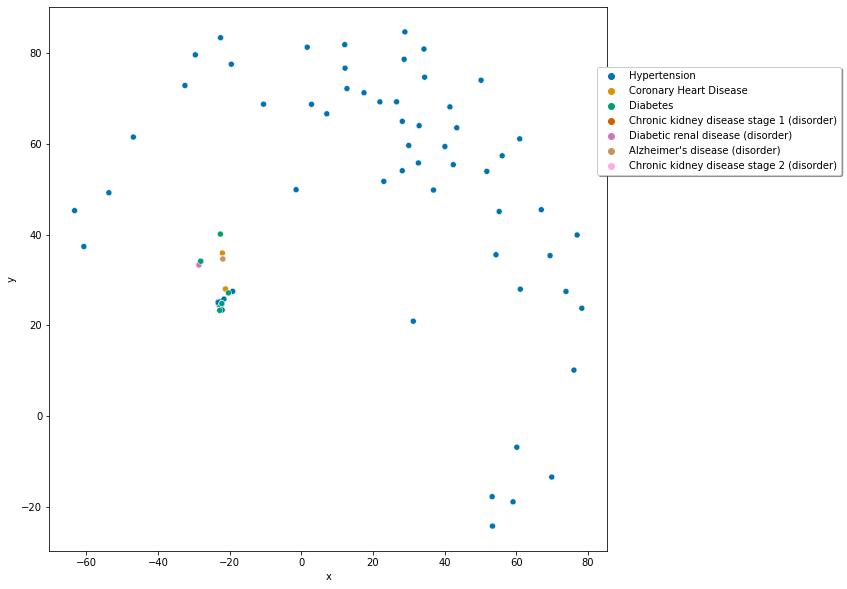

In [380]:
fig, ax = plt.subplots(figsize=(10, 10)) #each subplot of size 6x6, each row will hold 4 plots
df = pd.DataFrame.from_dict({'x':output_transformed[:,0],'y':output_transformed[:,1], 'labels':labels})
df = df[~df['labels'].isin(['[CLS]', '[SEP]', '[PAD]'])]
df['labels'] = df['labels'].apply(lambda x: code_to_desc[x])
df = df[df['labels'].str.contains('Hypertension|Diabetes|Chronic Kidney disease|kidney|Heart disease|Alzeimerz|Heart|heart|disease')]
sns.scatterplot(data=df,x='x',y='y',hue='labels',ax=ax, palette='colorblind')
ax.legend(loc='upper center', bbox_to_anchor=(1.2, 0.9),ncol=1, fancybox=True, shadow=True)